In [1]:
from model import *
from train_test_split import *
from predictionsGraph import *
from data_set import *
from torch.utils.data import DataLoader

In [2]:
seq_len = 3 #ovdje treba biti ista vrijednost kao kad se treniralo
batch_size = 1 #
hidden_dim = 1028
attention = True
train_data, val_data, test_data = load_data('real_for_all_podaci.csv') 
input_dim = train_data.shape[1]
train_dataset = Dataset(train_data, seq_len,'PRAM')
test_dataset = Dataset(test_data, seq_len,'PRAM')
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
train_loader = DataLoader(train_dataset, shuffle=False, batch_size=batch_size)
model = Net(input_dim,  hidden_dim = hidden_dim, seq_len=seq_len, attention=attention)

In [3]:
data = pd.read_csv('real_for_all_podaci.csv')
data = data[['PRAM', 'GOD', 'LOK']]
trainvalid_dataset_pom, test_dataset_pom = train_test_split(data, 'PRAM', locations = ['NS'], test_years=[2015,2016])
train_dataset_pom, valid_dataset_pom = train_test_split(trainvalid_dataset_pom, 'PRAM', locations = ['NS'], test_years = [2013,2014])
mean_PRAM = train_dataset_pom['PRAM'].mean()
def returnToStartingValues(value, mean):
    return (np.e**value-1)*mean

In [4]:
path_to_model = 'models/PRAM/batch_size_128-lr_0.0001-hidd_dim_1028_best.weights'
model.load_state_dict(torch.load(path_to_model))
model.eval()

Net(
  (lstm): LSTM(7, 1028, batch_first=True)
  (fc1): Linear(in_features=1028, out_features=1028, bias=True)
  (fc): Linear(in_features=1028, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (attention): Attention(
    (v): Linear(in_features=3, out_features=1, bias=True)
  )
)

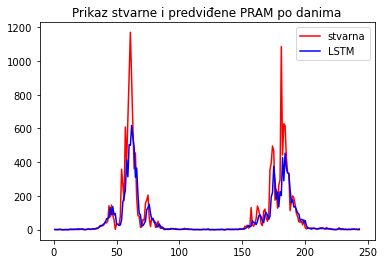

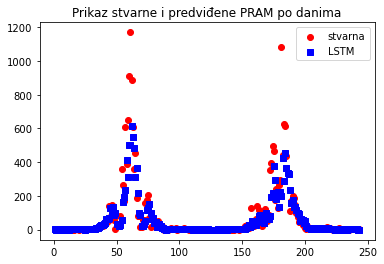

tensor(2442153.2500)


In [5]:
realValues = []
predictedValues = []
#h = model.lstm.weight_ih_l0
#h = model.init_hidden(batch_size)

for (inputs, labels) in test_loader:
    inputs, labels = inputs, labels 
    #print(inputs.shape)
    output = model(inputs)#, h)
    realValues.append(returnToStartingValues(labels.item(),mean_PRAM))
    predictedValues.append(returnToStartingValues(output.item(),mean_PRAM))
    
predictionsGraph(realValues, predictedValues)
predictionsGraphScatter(realValues, predictedValues)

loss_fn = nn.MSELoss(reduction='sum')
loss = loss_fn(torch.FloatTensor(realValues), torch.FloatTensor(predictedValues))
print(loss)

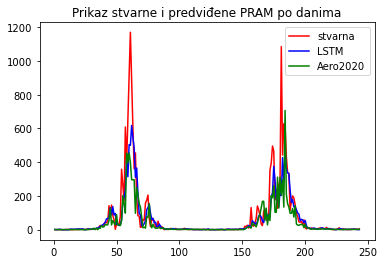

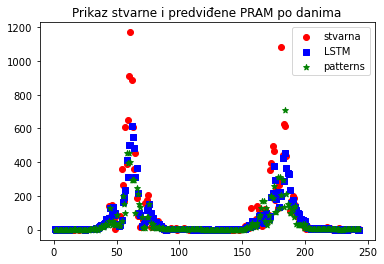

loss LSTM: tensor(2442153.2500) loss pattern: tensor(3576545.7500)


In [6]:
podaciZaCrtanje = pd.read_csv('ambrozija_NoviSad_patternPredictions.csv')
podaciZaCrtanje = podaciZaCrtanje.sort_values(by=['DAT'])
#print(podaciZaCrtanje)
staraPredvidjenaVrijednost = []
for i in range(len(podaciZaCrtanje)):
    staraPredvidjenaVrijednost.append(podaciZaCrtanje.iloc[i].predvidjenaVrijednost)
staraPredvidjenaVrijednost = staraPredvidjenaVrijednost[3:] #jer za prva 3 dana LSTM ne predvidja (tako su napravljeni podaci)
#aero2020PredvidjenaVrijednost = 
predictionsGraph(realValues, predictedValues, staraPredvidjenaVrijednost)
predictionsGraphScatter(realValues, predictedValues, staraPredvidjenaVrijednost)

loss_fn = nn.MSELoss(reduction='sum')
loss1 = loss_fn(torch.FloatTensor(realValues), torch.FloatTensor(predictedValues))
loss2 = loss_fn(torch.FloatTensor(realValues), torch.FloatTensor(staraPredvidjenaVrijednost))
print('loss LSTM:',loss1,'loss pattern:',loss2)

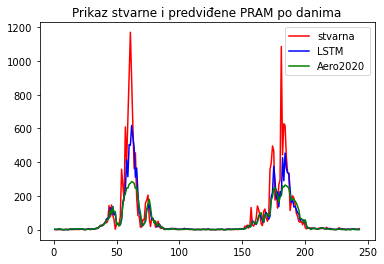

loss LSTM: tensor(2442153.2500) loss aero2020: tensor(3772648.2500)


In [7]:
aero2020_PRAM = pd.read_csv('aero2020_predictions/test_pram_lag=3_pred.csv', header = 0)
aero2020_PRAM = aero2020_PRAM.iloc[2:,:].reset_index()
aero2020_PRAM_predicted = list(map(lambda x: float(x), list(aero2020_PRAM['Neural Network'])))
aero2020_PRAM_predicted = list(map(lambda x: returnToStartingValues(x,mean_PRAM),aero2020_PRAM_predicted))
predictionsGraph(realValues, predictedValues, aero2020_PRAM_predicted)
loss1 = loss_fn(torch.FloatTensor(realValues), torch.FloatTensor(predictedValues))
loss2 = loss_fn(torch.FloatTensor(realValues), torch.FloatTensor(aero2020_PRAM_predicted))
print('loss LSTM:',loss1,'loss aero2020:',loss2)